# Empirical Orthongonal Functions I

This notebook will walk us through exercises using Empirical Orthongonal Function (EOF) or Principal Components Analysis (PCA), building on the in-class lecture.  Here we'll use a library called `xeofs`, which is built to work specifically with `xarray`.  See here: https://xeofs.readthedocs.io/en/latest/. We'll first look at a simple and classic dataset of iris flower dimensions, before tackling a 3 dimensional climate field. 

## Installing libraries

In order to install of the `xeofs` libraries, I suggest you use the `[complete]` suffix.  It is possible that your xarray may be out of date as well, so we can install all the packages using the same suffix.  

In [1]:
!pip install xeofs[complete]
#!pip install xarray[complete]


   ---------------------------------------- 0.0/63.7 kB ? eta -:--:--
   ------------------------- -------------- 41.0/63.7 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 63.7/63.7 kB 862.7 kB/s eta 0:00:00
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.2 MB 2.6 MB/s eta 0:00:01
   ----- ---------------------------------- 0.2/1.2 MB 2.6 MB/s eta 0:00:01
   ------- -------------------------------- 0.2/1.2 MB 2.1 MB/s eta 0:00:01
   ----------- ---------------------------- 0.3/1.2 MB 2.1 MB/s eta 0:00:01
   -------------- ------------------------- 0.4/1.2 MB 2.1 MB/s eta 0:00:01
   ------------------ --------------------- 0.6/1.2 MB 2.2 MB/s eta 0:00:01
   ------------------------- -------------- 0.8/1.2 MB 2.5 MB/s eta 0:00:01
   ---------------------------------- ----- 1.0/1.2 MB 2.9 MB/s eta 0:00:01
   ---------------------------------------  1.2/1.2 MB 3.1 MB/s eta 0:00:01
   --------------

If you are still getting compatibilities errors, here are a few things to try (ideally from the terminal or command line).  Note that if you run any of these solutions (or the ones above) in the notebook, you should restart the kernel so those changes take effect in your current session:

1. `pip check` - look to see what the incompatible dependencies are.  The most likely culprit is `numpy`, which recently went to version 2.0, but many packages might still have version 1.x requirement
2. `pip uninstall numpy xarray dask` followed by `pip install numpy xarray dask` to uninstall and reinstall these three packages, which often have dependenies. This will be easier to do from the terminal or command line.
3. If you're still getting errors that indicate a dependency problem, use `pip cache purge` and then `pip install --no-cache-dir numpy xarray` to get a really fresh start with these two libraries. 
4. If none of these work, don't worry.  Follow along in class and then chat with Kevin afterwards.  



Let's now get the other libraries we need.  Ths will be the first time we've imported xarray, so if you get any errors that indicate dependency problems (again, most likely between xarray and Numpy), see suggestions above.

In [44]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

# for the first time, let's import xarray - see here: https://docs.xarray.dev/en/stable/whats-new.html
import xarray as xr

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
# plt.rcParams['font.family'] = 'Helvetica'

Just a quick check to see what versions of Numpy and xarray we have:

In [5]:
print(np.__version__) 
print(xr.__version__) # latest version is 2024.9.0 which is from September 11, 2024; should work with Numpy 1.24 and below

1.26.4
2024.9.0


Another library we'll need is `Cartopy`, which will help us create maps.  If you need to install Cartopy, uncomment the line in the following block. Note that you may again encounter dependency or version issues here, especially if you have an existing installation of Numpy, xarray, and/or matplotlib:

In [9]:
!pip install cartopy


     ---------------------------------------- 0.0/56.0 kB ? eta -:--:--
     -------------------- ----------------- 30.7/56.0 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 56.0/56.0 kB 994.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   -- ------------------------------------- 0.6/11.0 MB 11.8 MB/s eta 0:00:01
   ----- ---------------------------------- 1.4/11.0 MB 14.6 MB/s eta 0:00:01
   --------- ------------------------------ 2.6/11.0 MB 15.1 MB/s eta 0:00:01
   ------------- -------------------------- 3.7/11.0 MB 14.7 MB/s eta 0:00:01
   --------------------- ------------------ 6.0/11.0 MB 16.0 MB/s eta 0:00:01
   ------------------------- -------------- 7.0/11.0 MB 16.6 MB/s eta 0:00:01
   ---------------------------------- ----- 9.5/11.0 MB 15.6 MB/s eta 0:00:01
   ---------------------------------------  10.7/11.0 MB 16.4 MB/s eta 0:00:01
   ---------------------------------------  11.0/11.0 MB 15.6 MB/s eta 0:

Cartopy enables use to create maps.  We'll import the library, as well as two specific functions: `ccrs` which handles the coordinate reference system (CRS), which allows us to create map projections and to transform latitude and longitude coordinates appropriately.  We will also bring in `cfeature`, which automates the process of drawing geographuc boundaries. 

In [46]:
# import cartopy 
import cartopy # base Cartopy
import cartopy.crs as ccrs # shortcut to the coordinate reference system
import cartopy.feature as cfeature # add map features

## EOF analysis of the Iris dataset

Let's use Pandas to read in the Iris data.  This dataset is described [here](https://en.wikipedia.org/wiki/Iris_flower_data_set).  It is often used to test classification algorithms and provides a nice tractable dataset for our first experimeents with EOFs: 

In [13]:
df = pd.read_csv('iris.data') # use Pandas to read in the csv data
df 

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species(id)
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In the code block below, we'll create a new smaller Pandas DataFrame with _only_ the sepal length and sepal width and only from the species _Iris setosa_.  

For this we'll use Pandas `.loc` with a long chain of specifics.  Note that the species selection (rows) and columns are in the square backets of the `.loc` method - so the row selection uses the command `.str.contains` applied to the species id column, and _then_ the column selection is of the two sepal related columns, enclosed together in square brackets.  The `.copy()` at the end ensures that sepal going forward will be not affected by any changes to the original df. 

In [15]:
sepal = df.loc[df[" species(id)"].str.contains('Iris-setosa'), ["sepal length (cm)"," sepal width (cm)"]].copy() # rows for Iris setosa, then the two sepal dimension columns
sepal # take a look:

,sepal length (cm),sepal width (cm)
0,5.1,3.5
1,4.9,3.0
2,4.7,3.2
3,4.6,3.1
4,5.0,3.6
5,5.4,3.9
6,4.6,3.4
7,5.0,3.4
8,4.4,2.9
9,4.9,3.1


We now have a new Pandas DataFrame with 50 rows and 2 columns. Let's scatter plot the data using Pandas object plotting ability.  To do this we tell Pandas the column name of the x and y values, and we can also pass it some plotting options.  The second line tries to set the aspect of the plot to be equal in both x and y directions:

In [ ]:
ax = sepal.plot.scatter(x="sepal length (cm)",y=" sepal width (cm)",color='Red',title='RAW DATA')
ax.set_aspect('equal', 'box')


Now, let's import `xeofs` as `xe`, following convention.  Because xeofs is an offshoot of xarray and therefore intended to accept DataArrays and Datasets, we'll need to [convert](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html) our Pandas DataFrame into one of these types.  Not only that, xeofs has certain expectations for the type of coordinate variables present in the dataset.  When we have latitude, longitude, and time (as we will below in the second part of the notebook), everything is fine.  But in this case we'll need to define the samples (e.g. the observations) and the features (e.g. the variables).  For our simple DataFrame the observations or samples are just the index values, which are just the numbers of each row.  The features or variables are each column.  The second command in the code block below therefore creates as DataArray by using the values in the sepal DataFeame, assigning two dimensions to the new xarray DataArray called 'samples' and 'features', and then specifies that the coordinates for the dimensions for samples are the index values (the row numbers), and the features are the column names:

In [17]:
import xeofs as xe # import xeofs

# turn our Pandas DataFrame into an xarray DataArray - see https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html
data_array = xr.DataArray(sepal.values, 
                          dims=('samples', 'features'), 
                          coords={'samples': sepal.index, 
                                  'features': sepal.columns})


We'll also remove the mean value from each column of the data array.  In fact, xeofs does this behind the scenes, but for our plotting purposes here, it will be easier for us to do it ourselves in advance:

In [18]:
feature_mean = data_array.mean(dim='samples')  # mean of each column, e.g. mean down the rows
data_array = data_array - feature_mean # remove the mean from each column - xarray is smart enough to know what you want to do here


Now we'll fit our EOF model.  It has similiar overall syntax to other types of models we've encountered - first we'll create the model object from the EOF class (which we'll call `model`), then pass that model the data array of our data, and specify that we want the dimension of the comparison to be between samples of each variable - or, in otherwords, what we are interested in is the paired observations from each of the sepal measurements.  In general, xeofs thinks about your data is either being a _sample_ or a _feature (from the [xeofs documentation](https://xeofs.readthedocs.io/en/latest/)):

> In this context, _sample_ refers to the dimension representing the number of observations. In contrast, _feature_ dimensions denote the variables. The main goal of dimensionality reduction techniques is to minimize the number of feature dimensions without altering the sample dimensions.

For more on the 'sample' vs. 'feature' structure that xeofs uses, see [here](https://xeofs.readthedocs.io/en/latest/content/user_guide/core_functionalities/labeled_data.html).  When we deal with datasets that have time and spatial dimensions (or time and variable dimensions), we are often trying to reduce the spatial or variable dimension while maintaining the time or sample or observation dimension.  This has been called 'S-Mode' PCA or EOF analysis.  

In other datasets, this distinction will be less clear.  And in [some cases](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/joc.1574), you might want to preserve the variable dimension while reducing the sampling dimension (also known as T-mode PCA or EOF).  If your data fall into this category and you would like to consider this approach to EOF analysis for your class project, please come and talk to me. 

Even these are simplifications of the wide range of possible ways to decomposite sample-feature (or space-time, or time-variable) covarying data into a reduced space of 

In [23]:
model = xe.single.EOF(n_modes=2) # create the model and produce two modes of variability
model.fit(data_array,dim='samples') # fit the model with our data, indicating we are operating along the sampling dimension - e.g. we want to use the covariance of each paired sample for our model


The model is now fit and from the `model` object we can extract a number of useful elements.  First, we can see how much (fractional) of the explained variance from the original dataset is explained by the new spatiotemporal modes, using `.explained_variance_ratio()`.  

In [25]:
expvar = model.explained_variance_ratio()
expvar


<xarray.DataArray 'explained_variance_ratio' (mode: 2)> Size: 16B
array([0.87428275, 0.12571725])
Coordinates:
  * mode     (mode) int32 8B 1 2
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.3
    date:           2024-10-14 13:38:02
    n_modes:        2
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

You can see the first new mode explains about 87% of the total variability in the original data, whereas the second mode accounts for the remaining ~13%.

We can also get out the `.components`, which we also call the eigenvectors, the loadings or the EOFs.  For (geometrically) simple datasets, we can think of these as describing the new normalized vectors through our original data that capture the new leading modes of variation.  When we move to higher and higher order problems (e.g. where we have tens, hundreds, or thousands of variables), the geometric definition still holds, but it may be more more useful think about these as how each of the original data series weights on or contributes to the respective mode of variability. 

In [27]:
eofs = model.components()
eofs


<xarray.DataArray 'components' (mode: 2, features: 2)> Size: 32B
array([[ 0.66941065,  0.74289258],
       [ 0.74289258, -0.66941065]])
Coordinates:
  * mode      (mode) int32 8B 1 2
  * features  (features) object 16B 'sepal length (cm)' ' sepal width (cm)'
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.3
    date:           2024-10-14 13:38:02
    n_modes:        2
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

Notice that the EOFs (eigenvectors, loadings) have dimensions of modes vs. features.  Or, that for each new mode, each of the original features (our two axes in this case) has a value. 

We can also get the scores, timeseries, or PCs for our new modes.  These are the new timeseries corresponding to the loadings and will have the same sample (often time) dimension as the original data.  We can understand these are overall behavior of the spatial patterns we get from the modes or, alternatively, the weighted average of the contribution of each of the original data points to the temporal variability of this mode.  Notice here the dimensions of the scores are mode number by the original sampling dimension. 

In [ ]:
pcs = model.scores()
pcs

Let's make a plot to see how these new modes, with their eignevectors and associated explained variance, map onto the original data:

In [ ]:
plt.figure(figsize=[5,5])
ax = plt.axes()

ax.scatter(data_array[:,0],data_array[:,1],color='black')

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

# the vector described by the first eigenvalue (column 0 of U)
lx1 = ax.plot([-eofs[1,0],eofs[1,0]],[-eofs[0,0],eofs[0,0]],color='red');
lx2 = ax.plot([-eofs[1,1],eofs[1,1]], [-eofs[0,1],eofs[0,1]],color='blue');
ax.set_aspect('equal', 'box')

# place the explained variance for each new eigenvector on the plot
ax.text(0.70, 0.75, f'{expvar.values[0] * 100:.1f}%', fontsize=18, color='red')
ax.text(-0.75,0.79,f'{expvar.values[1] * 100:.1f}%',fontsize=14,color='blue', horizontalalignment='center')

plt.show()

In the plot above we see that our new eigenvectors describe next axes through our data points such that the first eigenvector (the red line) bisects the data in such a way as to capture most of the variability in the system.  The second new eigenvalue is _orthogonal_ to the first, and captures the remaining variability not associated with the position along the red line (e.g. the blue line captures the scatter of the points around the red line).  

We can also plot the scores.  In this simple example, the scores appears simply as the rotatation of the original points onto a new set of axes defined by the eigenvectors.  We now can see also that the value of any of the new points relative to the new x axis (the first eigenvector) is unrelated to the value with respect to the new y axis (the second eigenvalue).  So, not only are the eigenvectors orthongonal (at right angles to one another), but the corresponding scores are not correlated!  

In [ ]:
plt.figure(figsize=[5,5])
ax = plt.axes()

ax.scatter(pcs[0,:],pcs[1,:],color='black')

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xlabel('MODE 1 SCORE')
ax.set_ylabel('MODE 2 SCORE')

ax.set_aspect('equal', 'box')

ax.plot([-1,1],[0,0], color="red")
ax.plot([0,0],[-1,1], color="blue")


plt.show()

Let's look at a larger dimensional problem now to try and understand how EOF analysis works when applied to a bigger data set. 

## EOF analysis of a spatiotemporal field

Let's deal with a more realistic example from climate science.  Here we seek to use EOF analysis to identify the leading coupled space-time patterns of co/variance in tropical and North Pacific sea surface temperature (SST) anomalies in a gridded dataset. 

>'Given any space-time meteorological field, EOF analysis finds a set of orthogonal spatial patterns along with a set of associated uncorrelated time series or principal components (PCs)' [Hannachi et al. (2007)](https://doi.org/10.1002/joc.1499)

In this 2nd part of this notebook notebook, we'll see how to find these new paired space-time patterns in a 3-dimensional field (time, latitude, longitude) of climate data.

We'll first read in the data from a netcdf file, deal with missing data points, modify the coordinate system to make our lives easier, and then slice out the spatial domain we want.  We'll then create a seasonal winter average, reshape our data, calculate the covariance matrix of our field, and find the eigenvectors and eigenvalues using singular value decomposition.  Having done that, we'll calculate the time series expansion for our leading EOF patterns (called signals, scores, or PCs), and plot our new space-time modes so we can interpret them.  

We'll first open our sea surface temperature dataset using xarray and then we'll move onto dealing with missing data and changing the coordinate system.  `xarray.open_dataset` quickly and easily opens our netcdf file.  

The data we're using is the Hadley Centre Sea Ice and Sea Surface Temperature data set (HadISST), available here: https://www.metoffice.gov.uk/hadobs/hadisst/.  It contains globally-complete fields of SST and sea ice concentration on a 1 degree latitude-longitude grid from 1870 to the present.  It is too large to host on Github unfortunately, but you can get it directly from the link above or from the course D2L page.

In [6]:
# open our netcdf file into a DataSet and take a look:
ds = xr.open_dataset('./HadISST_sst.nc') 
ds

<xarray.Dataset> Size: 481MB
Dimensions:    (time: 1856, nv: 2, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 2...
  * latitude   (latitude) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 15kB ...
    sst        (time, latitude, longitude) float32 481MB ...
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    2/10/2024 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

We can see that xarray creates a very nice data structure, called a DataSet, which can have multiple variables - it has dimensions, coordinates, data variables with corresponding coordinate, and even metadata.

Let's pull out just the SST data variable from the Dataset - it will bring all the coordinate systems with it as a new single variable DataArray.

In [8]:
# pull the sst variable out of the DataSet. You can see it is now a DataArray with all the coordinate information brought along
sst = ds.sst
sst

<xarray.DataArray 'sst' (time: 1856, latitude: 180, longitude: 360)> Size: 481MB
[120268800 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 2...
  * latitude   (latitude) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

We have to do a few things now - first, we need to deal with sporadically missing data due to the presence of sea ice.  We can use xarray's DataArray `.where`, but [please note it functions slightly differently than Pandas's equivalent](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.where.html#xarray.DataArray.where)! 

In [11]:
# turn negative SST values in NaN
sst = sst.where(sst >= -4, np.nan) # note that when applied to a DataArray, the where operates a bit differently! https://docs.xarray.dev/en/stable/generated/xarray.DataArray.where.html#xarray.DataArray.where

nan_mask = sst.isnull().any(dim='time')
sst = sst.where(~nan_mask, np.nan)


We'll also transform the coordinate system from longitude that go from -180 to 180 to one that goes from 0 to 360, which is easier to deal with for our Pacific Ocean domain:

In [13]:
# change the longitudes from -180,180 to 0,360 - see here: https://docs.xarray.dev/en/stable/generated/xarray.Dataset.assign_coords.html
sst = sst.assign_coords(longitude=(sst.longitude % 360))

# now, sort the coordinates and associated data so they are in the correct order from 0 to 360 - see here: https://docs.xarray.dev/en/latest/generated/xarray.DataArray.sortby.html
sst = sst.sortby(sst.longitude)

Let's do a quick sanity check now - any time we do things like deal with missing values or transform coordinates, we should make a map of spatial data to make sure nothing looks amiss:

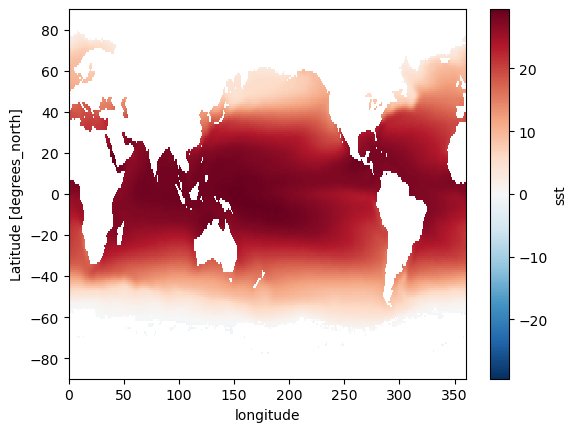

In [16]:
sst.mean(dim="time").plot() # this says 'hey, xarray, take the mean over all the time points and plot the 2d result

So far, so good - the tropics are warm, the continents are in the right place, missing values that are not continents are in regions of sea ice.  So we proceed.

Next we are going to slice out just our desired spatial domain in the tropical and North Pacific Ocean.  We'll use a combination of [.sel](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.sel.html) and [.slice](https://docs.xarray.dev/en/latest/user-guide/indexing.html) here to select a range of latitude and longitude values to extract. 

In [18]:
# latitude bounds
min_lat = -20.0
max_lat = 60.00

# longitude bounds
min_lon = 120
max_lon = 280

# select a slice and overwrite sst with the output and then take a look
sst = sst.sel(longitude=slice(min_lon,max_lon),latitude=slice(max_lat,min_lat))
sst


<xarray.DataArray 'sst' (time: 1856, latitude: 80, longitude: 160)> Size: 95MB
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [29.362446, 29.487097, 29.582   , ..., 21.367596, 21.490658,
         21.701618],
        [29.349419, 29.494856,       nan, ..., 20.816582, 20.896683,
         21.1602  ],
        [29.328918,       nan,       nan, ..., 20.44212 , 20.459213,
         20.71367 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [25.671772, 25.509834, 25.469355, ..., 18.83667 , 18.578512,
         18.238094],
        [25.16539 , 25.202036,       nan, ..., 18.772577, 18.6128  ,
         18.337353],
        [25.012398,       nan,       nan, ..., 18.789112, 18.613129,
         18.36205 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [26.038895, 25.92184 , 25.9656  , ..., 18.317589, 18.299786,
         18.179369],
        [25.604773, 25.7686  ,       nan, ..., 18.266872, 18.362007,
         18.292252],
        [25.356653,       nan,       nan, ..., 18.30494 , 18.364174,
         18.296864]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 2...
  * latitude   (latitude) float32 320B 59.5 58.5 57.5 56.5 ... -17.5 -18.5 -19.5
  * longitude  (longitude) float32 640B 120.5 121.5 122.5 ... 277.5 278.5 279.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

Let's make another sanity check map:

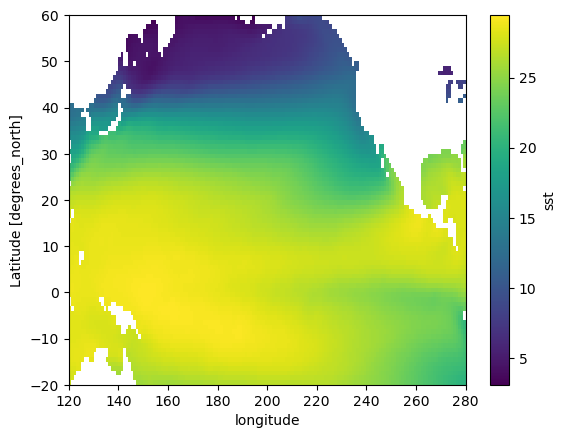

In [20]:
sst.mean(dim="time").plot() # this says 'hey, xarray, take the mean over all the time points and plot the 2d result

Looks OK still. 

Next, we want to calculate the monthly mean value for each month - we'll use [.groupby](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html) to group all the data by their month (January, February, etc.) and the apply [.mean](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.mean.html) with along the dimension of 'time' to get 12 monthly average SST values, one for each month.  We then get _anomalies_ from the monthly mean by subtracting the appropriate monthly mean from each set of monthly values.  

In [23]:
# calculate the monthly mean at each point - climatology
sst_clm = sst.groupby('time.month').mean(dim='time')

# calculate the anomaly anomaly - use groupby to tell xarray that sst_clm should be applied to each group of months, since sst_clm has only 12 time coordinate points
sst_anom = sst.groupby('time.month') - sst_clm

Finally, let's calculate a seasonal mean value over the boreal winter from December to February.  There are a few ways to do this, but I find this the easiest:  Create a [.rolling]() 3-month mean value, then select only the values where the (ending) month is month number 2, February.  This will give us a new variable `djf` which is the average of the prior December, January, and February.  

In [25]:
# Calculate the 3-month rolling mean, skipping NaN values
sst_ = sst_anom.rolling(time=3).mean(skipna=True)

# Select out month 2 (February) to get the average over DJF
djf = sst_[sst_.time.dt.month == 2]

# take a look
djf

<xarray.DataArray 'sst' (time: 155, latitude: 80, longitude: 160)> Size: 8MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.00369136, -0.05651347, -0.17807198, ...,  0.07247035,
          0.18909773,  0.20443854],
        [-0.03231621, -0.04246267,         nan, ...,  0.12878165,
          0.26393384,  0.29541144],
        [-0.06258901,         nan,         nan, ...,  0.07963499,
          0.1783123 ,  0.24974442]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.17580986,  0.17547417,  0.140035  , ..., -0.4243533 ,
         -0.4460551 , -0.32258034],
        [ 0.08410518,  0.14122137,         nan, ..., -0.46565056,
         -0.52181756, -0.41674232],
        [ 0.03886732,         nan,         nan, ..., -0.40131378,
         -0.4338023 , -0.37253255]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1kB 1870-02-14T23:59:59.340820312 ... 20...
  * latitude   (latitude) float32 320B 59.5 58.5 57.5 56.5 ... -17.5 -18.5 -19.5
  * longitude  (longitude) float32 640B 120.5 121.5 122.5 ... 277.5 278.5 279.5
    month      (time) int64 1kB 2 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2 2 2

Making a cross-year rolling average creates a completely missing first value (e.g. because there was no December to average) - we can see this by plotting just the first value in our new winter SST variable:

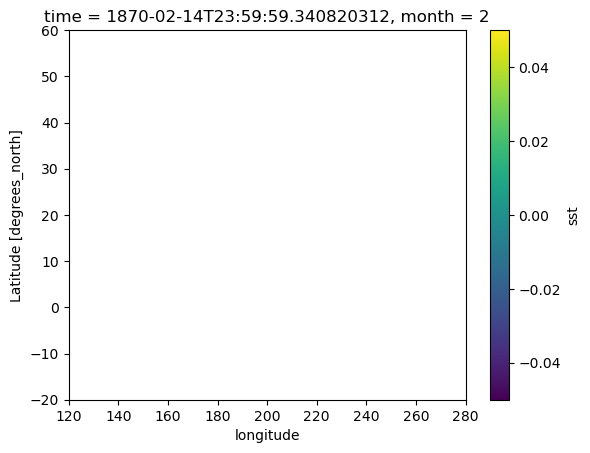

In [27]:
djf.isel(time=0).plot() # map is empty, compare to winter.isel(time=1).plot() in the next code block!

We can remove this null data value using [.drop_sel](https://docs.xarray.dev/en/latest/generated/xarray.Dataset.drop_sel.html) and indicating the 0th (first) time point in the dataset.  Then we check again:

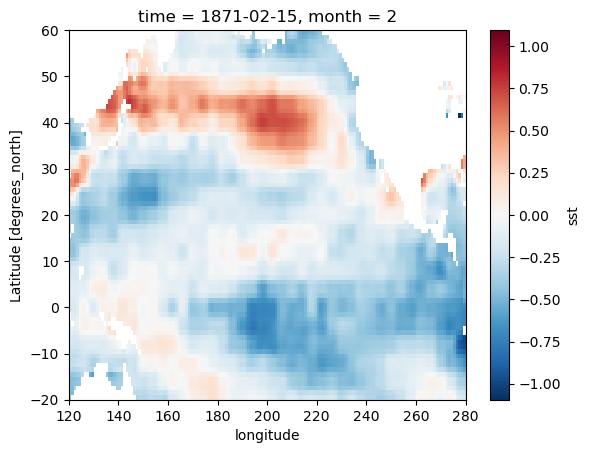

In [29]:
# use drop_isel to drop the first year and reassign to winter
djf = djf.drop_isel(time=0)

# look at winter again - note the 153 years of winter averages and the first date in March 1871
djf.isel(time=0).plot() # map is empty, compare to winter.isel(time=1).plot() in the next code block!


This now looks correct.

Now, let's do our EOF analysis -- we call `xe` and the single dataset EOF model.  This time we weight by the cosine of the latitude by setting `use_coslat=True`.  We then fit the model, indicating the sampling dimension is 'time'.  And we can extract the explained variance once again for our leading 5 modes:

In [33]:
import xeofs as xe
model = xe.single.EOF(n_modes=5,use_coslat=True)

model.fit(djf, dim="time")

expvar = model.explained_variance_ratio()
expvar

<xarray.DataArray 'explained_variance_ratio' (mode: 5)> Size: 40B
array([0.44340094, 0.18412014, 0.06349293, 0.04994225, 0.03006677])
Coordinates:
  * mode     (mode) int32 20B 1 2 3 4 5
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.3
    date:           2024-10-16 13:27:13
    n_modes:        5
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

We can make a quick stem plot to illustrate how the variance is partioned amongst the leading modes:

Text(0, 0.5, '% VARIANCE EXPLAINED')

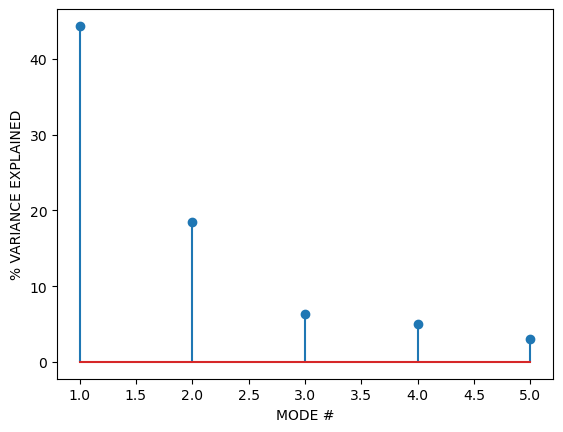

In [34]:
plt.stem(np.arange(1,6),expvar*100)
plt.xlabel('MODE #')
plt.ylabel('% VARIANCE EXPLAINED')

Now we get the EOFs (or loadings or eignevectors):

In [37]:
eofs = model.components()
eofs 

<xarray.DataArray 'components' (mode: 5, latitude: 80, longitude: 160)> Size: 512kB
array([[[ 0.0001291 ,         nan,         nan, ...,  0.00612892,
          0.00557174,  0.00530319],
        [ 0.00035656,  0.00074344,         nan, ...,  0.00565371,
          0.00507527,  0.00524864],
        [ 0.00101165,  0.00101912,  0.00090387, ...,  0.00548981,
          0.00523099,  0.00590215],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.00286014,         nan,         nan, ..., -0.00272473,
         -0.00255637, -0.00220521],
        [ 0.00311514,  0.00178967,         nan, ..., -0.00315818,
         -0.00301849, -0.00254449],
        [ 0.00374298,  0.00209808, -0.00103219, ..., -0.00415186,
         -0.00399849, -0.00341526],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.00146946,         nan,         nan, ..., -0.01003925,
         -0.00944928, -0.0102668 ],
        [ 0.00202154,  0.00277665,         nan, ..., -0.01177487,
         -0.01161756, -0.01206407],
        [ 0.00283087,  0.00321055,  0.00328345, ..., -0.01395598,
         -0.01415427, -0.01443903],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * latitude   (latitude) float32 320B -19.5 -18.5 -17.5 ... 57.5 58.5 59.5
  * longitude  (longitude) float32 640B 120.5 121.5 122.5 ... 277.5 278.5 279.5
  * mode       (mode) int32 20B 1 2 3 4 5
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.3
    date:           2024-10-16 13:27:13
    n_modes:        5
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

Observe that the dimensions of the loadings are modes x latitude x longitude.  That is, for each new mode, we have a loading value at each location where we had original SST time series.  The time dimension is not present - the loadings are telling us about the contribution of the original SST data to the new patterns.

Now we get the scores (or PCs, or time series expansion):

In [39]:
pcs = model.scores()
pcs

<xarray.DataArray 'scores' (mode: 5, time: 154)> Size: 6kB
array([[-2.38786685e+01, -3.30688721e+01, -4.57926412e+01,
        -4.70323448e+01, -3.37586563e+01, -4.97245377e+01,
         1.20993693e+01,  9.59149230e+01, -7.93915599e+00,
        -3.12869058e+01,  5.44634150e+00, -2.37361084e+01,
        -2.29843612e+01, -1.04113946e+01,  1.74977688e+01,
         1.26338968e+01, -4.09643615e+01,  4.50639725e+00,
         6.58675956e+01, -6.31424914e+01, -1.80699149e+01,
        -1.21919293e+01, -5.30152725e+01, -4.81985555e+01,
        -2.29523128e+01,  8.63266329e+00,  4.92585730e+01,
        -2.07026801e+01, -2.29513106e+01,  5.54176995e+01,
         2.35300740e+01,  6.15190018e-01,  3.51536071e+01,
        -2.91275009e+01,  3.69234167e+01,  3.40343908e+01,
        -2.33672958e+01, -5.22959182e+00, -3.00090998e+01,
        -5.15070002e+01, -3.16000407e+01,  3.83215675e+01,
        -7.82210604e+00,  2.42429358e+01,  3.10229756e+01,
        -1.88704458e+01, -6.42279041e+01, -3.93560069e+01,
         5.03963990e+01,  1.90532162e+01, -8.31535460e+00,
        -1.66377210e+01, -2.55442093e+01,  9.58393127e+00,
        -3.00565274e+01,  5.38475704e+01,  1.36467985e+01,
         9.51930437e+00, -9.99058043e+00,  1.64895896e+01,
...
         8.96590234e+00,  6.57640131e+00,  1.58283862e+01,
         1.96383224e+00, -6.84217489e+00, -3.56937939e+00,
        -1.08460487e+01, -8.38947596e+00, -2.40617653e+00,
        -4.64585465e+00, -1.01668068e+01,  1.31092862e+01,
         4.32655177e+00,  8.20926705e+00,  3.17244053e+00,
        -1.88785394e+00, -2.28217939e+01, -7.69667466e+00,
        -6.08327435e+00, -2.44102136e+00, -3.57114653e+00,
         2.63923568e+01, -3.54903548e+00, -2.20291467e+00,
         3.42933050e-01, -4.05843277e+00,  8.04891767e+00,
         7.36577039e+00,  2.15929986e+00, -1.42337487e+01,
        -4.62711912e+00, -2.66603931e+01,  1.72640261e-01,
         8.88580048e+00,  4.48868100e+00,  1.66545926e+01,
         8.66458104e+00,  9.33624270e-01, -2.15718368e-01,
        -2.80726957e+00,  8.08419037e+00,  7.30031810e+00,
        -4.85062625e+00,  1.10251736e+01, -4.05039519e+00,
        -8.73772382e+00,  5.94119195e+00, -1.41547245e+01,
        -3.60562060e+00, -5.80515778e+00,  7.79322267e+00,
         1.37212255e+01,  2.36356886e+00,  5.08676927e+00,
        -3.39301264e+00, -4.86586586e-01, -1.13938008e+01,
        -6.50500209e+00]])
Coordinates:
  * time     (time) datetime64[ns] 1kB 1871-02-15 ... 2024-02-15T12:00:00
    month    (time) int64 1kB 2 2 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2 2 2
  * mode     (mode) int32 20B 1 2 3 4 5
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.3
    date:           2024-10-16 13:27:13
    n_modes:        5
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

Again note the dimensions of the data are mode x time.  So the PCs (scores, etc.) are the temporal expression of the spatial pattern shown by the loadings. 

Let's plot our data:

C:\Users\mayae\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


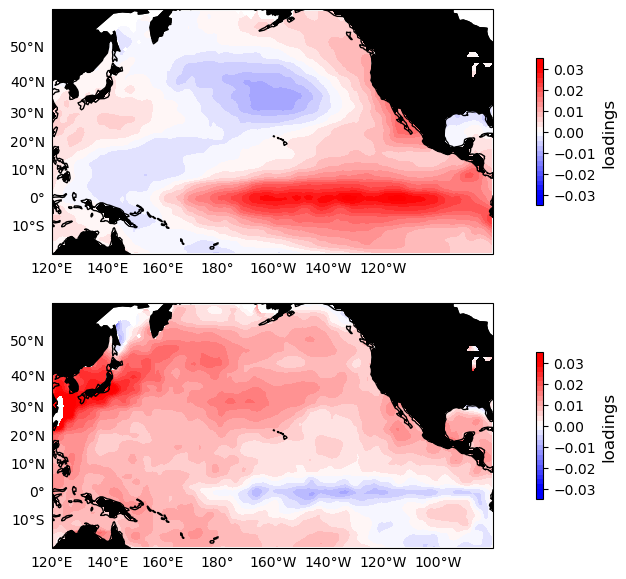

In [48]:
# because .subplots creates the axes, we can tell it about the Cartopy projection here!
fig, axs = plt.subplots(num=1, figsize=(11,7), clear=True,nrows=2,ncols=1,subplot_kw={'projection': ccrs.Miller(central_longitude=260)})

## plot the first axis with a map of the leading (0th) EOF loadings
# plot the coastlines as before
axs[0].coastlines(color="black")  # we can pass arguments to .coastlines function
axs[0].add_feature(cfeature.LAND, color='black') # this uses Cartopy and Natural Earth features to fill the continents black

# specifying the levels of the contour plot we're going to plot gives us more control on the map and colorbar
levels = np.linspace(-0.035, 0.035, 31)

# plot filled contours, specify the levels of the contour intervals, the minimum and maximum values, and specify ccrs.PlateCarree() and use the bwr (blue-white-red) colormap
px1 = axs[0].contourf(eofs.longitude,eofs.latitude,eofs.sel(mode=1), levels=levels,vmin=-0.03, vmax=0.03, cmap="bwr",transform=ccrs.PlateCarree())

# Here is where we set the longitude and latitude extent the order is: (longitude1, longitude2, latitude1, latitude2)
axs[0].set_extent([120, 280, -20, 60],crs=ccrs.PlateCarree())

# we can make the axes look like we want - here we remove the gridlines, put tell matplotlib where to put axes tickmarks
gl1 = axs[0].gridlines(color='None', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=[-10, 0, 10, 20, 30, 40, 50, 60], xlocs=[120, 140, 160, 180, -160, -140, -120, -100 -80])

# we would like a colorbar to allow us to interpret the contour plot - we tell the colorbar which contour plot it is describing by the handle, here 'px1' from above 
cb1 = plt.colorbar(px1, orientation='vertical',shrink=0.6,ticks=[-0.03, -0.02, -0.01, 0, 0.01, 0.02, 0.03])
cb1.set_label('loadings', fontsize=12) # at this point, the EOFs don't really have a unit, so we put values or we could put 'loadings' 

## plot the second axis, now with the second EOF mode (1st-ith)
 
# plot the coastlines as before
axs[1].coastlines(color="black")  # we can pass arguments to .coastlines function
axs[1].add_feature(cfeature.LAND, color='black')

# specifying the levels gives us more control on the map
levels = np.linspace(-0.035, 0.035, 31)

# plot contour and specify ccrs.PlateCarree() and use bwr (blue-white-red) colormap
px2 = axs[1].contourf(eofs.longitude, eofs.latitude, eofs.sel(mode=2), levels=levels,vmin=-0.03, vmax=0.03, cmap="bwr",transform=ccrs.PlateCarree())

# Here is where we set the longitude and latitude extent
axs[1].set_extent([120, 280, -20, 60],crs=ccrs.PlateCarree())

gl1 = axs[1].gridlines(color='None', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=[-10, 0, 10, 20, 30, 40, 50, 60], xlocs=[120, 140, 160, 180, -160, -140, -120, -100])
 
# we would like a colorbar to allow us to interpret the contour plot - we tell the colorbar which contour plot it is describing by the handle, here 'px2' from above 
cb2 = plt.colorbar(px2, orientation='vertical',shrink=0.6,ticks=[-0.03, -0.02, -0.01, 0, 0.01, 0.02, 0.03])
cb2.set_label('loadings', fontsize=12) # at this point, the EOFs don't really have a unit, so we put values or we could put 'loadings' 
 

The first pattern should look familiar to those of you that have training in climatology.  The second pattern suggests the same sign anomalies everywhere except a thin strip of opposite signed loadings in the eastern equatorial Pacific.

Let do another plot that includes not only the EOFs but the PCs, too:

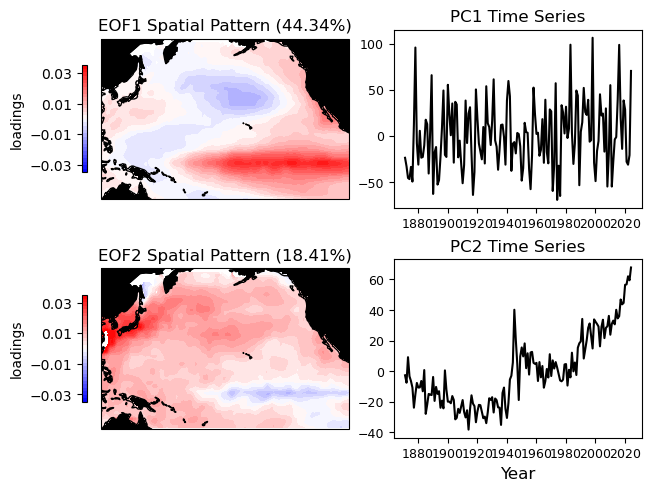

In [50]:
fig=plt.figure(layout="constrained")
gs = fig.add_gridspec(2, 2) # make a 2 row and 2 column spaces
gs.update(wspace=-1, hspace=-0) # we can control some of the spacing on the gridspec

expvar_percentage = expvar * 100

projection=ccrs.Miller(central_longitude=260)# Miller projection centered on the North Pacific

# first subplot, upper left position, map of EOF1 loadings
ax1 = fig.add_subplot(gs[0, 0], projection=projection) # map plot in 1st column of grid
fx1 = ax1.contourf(eofs.longitude,eofs.latitude,eofs.sel(mode=1),levels=levels, cmap='bwr', transform=ccrs.PlateCarree())
ax1.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax1.coastlines(color="black") 
ax1.add_feature(cfeature.LAND, color='black')
ax1.set_title(f"EOF1 Spatial Pattern ({expvar_percentage[0]:.2f}%)", fontsize=12)
cb1 = plt.colorbar(fx1, orientation='vertical',location='left',shrink=0.6,ticks=[-0.03, -0.01, 0.01, 0.03])
cb1.set_label('loadings', fontsize=10) 

# second subplot, upper right position, time series plot of PC1 time series corresponding to EOF1
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(pcs.time,pcs.sel(mode=1),color="black")
ax2.set_title('PC1 Time Series', fontsize=12)
ax2.tick_params(axis="x",labelsize=9)
ax2.tick_params(axis="y",labelsize=9)

# third subplot, lower left position, map of EOF2 loadings
ax3 = fig.add_subplot(gs[1, 0], projection=projection) # map plot in 1st column of grid
fx3 = ax3.contourf(eofs.longitude,eofs.latitude,eofs.sel(mode=2),levels=levels, cmap='bwr', transform=ccrs.PlateCarree())
ax3.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax3.coastlines(color="black")  
ax3.add_feature(cfeature.LAND, color='black')
ax3.set_title(f"EOF2 Spatial Pattern ({expvar_percentage[1]:.2f}%)", fontsize=12)
cb3 = plt.colorbar(fx3, orientation='vertical',location='left',shrink=0.6,ticks=[-0.03, -0.01, 0.01, 0.03])
cb3.set_label('loadings', fontsize=10) 

# last subplot, lower right position, time series plot of PC2 time series corresponding to EOF2
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(pcs.time,pcs.sel(mode=2),color="black")
ax4.set_xlabel('Year',fontsize=12)
ax4.set_title('PC2 Time Series', fontsize=12)
ax4.tick_params(axis="x",labelsize=9)
ax4.tick_params(axis="y",labelsize=9)

We'll discuss the interpretation of these in class.

## Next Steps

1. See below how changing which dimension we calculate the EOF over changes the interpretation of the space/time patterns of variability and how specifically the interpretations of the spatial patterns and the temporal expansion vary as a consequence. 
2. Look at some of the other options for `xeofs` - specifically, what do the following [options](https://xeofs.readthedocs.io/en/latest/content/api_reference/_autosummary/xeofs.single.EOF.html) do? `standardize`, `transform`, `inverse_transform`? 
3. Look at what `inverse_transform` does.  What happens if you call `inverse_transform` with only a subset of the modes you extracted?  How does it compare to the original data field (e.g. the mean or standard deviation of the original data field)?
4. Play around with [Cartopy](https://scitools.org.uk/cartopy/docs/latest/index.html) - what options are available for creating publication-ready maps automatically from code?  

## Experimenting with T-mode EOF

Thus far we've used the relationship between two or more variables (either paired variables on the same individual flower with the iris dataset, or simulataneous in time measurements of SST) as the basis for our EOF analysis.  The eigenvectors and eigenvalues are therefore reflecting how different variables (or the same variable at different locations) covary with one another.  There is another approach, however, often called T-mode EOF or PCA, where the covariance is between strung-out-vectors of all the data points at a single time.  Or, in otherwords, instead of the columns of our data being the value of a particular variable or location, and each row being an observation or time point of each of those variables, we could imagine the columns to reflect every single value at every single latitude and longitude point in a given year, and therefore each column would reflect the ordered spatial values of a given year.  In this case, the covariance relationship that would form the basis of the eigendecomposition would be the similarity between the maps of different years, essentially.

Note that in strongly coupled systems, temporal and spatial variability are often closely linked.  For instance, SSTs in the cold tongue region of the tropical Pacific covary with one another through time, but also in years with a strong ENSO 

In [585]:
tmodel = xe.single.EOF(n_modes=5)
tmodel.fit(djf, dim=("latitude", "longitude"))
teofs = tmodel.components() # this will now be 5 modes by 153 samples
tpcs = tmodel.scores() # this will be 5 modes by the latitude and longitude grid size


In [ ]:
fig=plt.figure(layout="constrained")
gs = fig.add_gridspec(2, 2) # make a 3 row and 2 column spaces
gs.update(wspace=-1, hspace=-0) # we can control some of the spacing on the gridspec

projection=ccrs.Miller(central_longitude=260)# Miller projection centered on the North Pacific

# first subplot, upper left position, map of EOF1 loadings
ax1 = fig.add_subplot(gs[0, 0], projection=projection) # map plot in 1st column of grid
fx1 = ax1.contourf(tpcs.longitude,tpcs.latitude,tpcs.sel(mode=1), cmap='bwr', transform=ccrs.PlateCarree())
ax1.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax1.coastlines(color="black") 
ax1.add_feature(cfeature.LAND, color='black')
ax1.set_title('Mode 1 Spatial Pattern', fontsize=12)
cb1 = plt.colorbar(fx1, orientation='vertical',location='left',shrink=0.6)
cb1.set_label('loadings', fontsize=10) 

# second subplot, upper right position, time series plot of PC1 time series corresponding to EOF1
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(teofs.time,teofs.sel(mode=1),color="black")
ax2.set_title('Mode 1 Similarity', fontsize=12)
ax2.tick_params(axis="x",labelsize=9)
ax2.tick_params(axis="y",labelsize=9)

# third subplot, lower left position, map of EOF2 loadings
ax3 = fig.add_subplot(gs[1, 0], projection=projection) # map plot in 1st column of grid
fx3 = ax3.contourf(tpcs.longitude,tpcs.latitude,tpcs.sel(mode=2),cmap='bwr', transform=ccrs.PlateCarree())
ax3.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax3.coastlines(color="black")  
ax3.add_feature(cfeature.LAND, color='black')
ax3.set_title('Mode 2 Spatial Pattern', fontsize=12)
cb3 = plt.colorbar(fx3, orientation='vertical',location='left',shrink=0.6)
cb3.set_label('loadings', fontsize=10) 

# fourth subplot, lower right position, time series plot of PC2 time series corresponding to EOF2
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(teofs.time,teofs.sel(mode=2),color="black")
ax4.set_xlabel('Year',fontsize=12)
ax4.set_title('Mode 2 Similarity', fontsize=12)
ax4.tick_params(axis="x",labelsize=9)
ax4.tick_params(axis="y",labelsize=9)
